# First Attempts for CS69.9/169.9 Kaggle Challenge

**Authors & Affiliation**: David C. & Sunint B. Dartmouth College, Hanover NH 03755

**Acknowledgements** We acknowledge in advance for Kagglers' who shared their code publicly, numerous online documentations, blog posts, Q&A (e.g. StackOverflow), and dataset providers.

Conceptual tutorial that helped a lot: [here](https://lilianweng.github.io/lil-log/2017/12/31/object-recognition-for-dummies-part-3.html#r-cnn)

First, install dependencies (needs to run _every time_ running this notebook) and weight file. 

In [1]:
## In Kaggle kernel, these packages at the right version needs to be install EVERY time! (This is a LIMITATION)
!pip3 uninstall tensorflow --yes
!pip3 uninstall keras --yes
!pip3 install tensorflow==1.15.0
!pip3 install fancyimpute==0.5.4
!pip3 install keras==2.1.5
!pip3 install mrcnn

## Weight for fine-tuning (available on GitHub):
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.1/mask_rcnn_balloon.h5

Found existing installation: tensorflow 2.1.0
Uninstalling tensorflow-2.1.0:
  Successfully uninstalled tensorflow-2.1.0
Found existing installation: Keras 2.3.1
Uninstalling Keras-2.3.1:
  Successfully uninstalled Keras-2.3.1
     |████████████████████████████████| 412.3 MB 14 kB/s s eta 0:00:01
     |████████████████████████████████| 3.8 MB 47.3 MB/s eta 0:00:01
     |████████████████████████████████| 503 kB 33.7 MB/s eta 0:00:01
ERROR: fancyimpute 0.5.4 requires keras>=2.0.0, which is not installed.
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.1.1
    Uninstalling tensorboard-2.1.1:
      Successfully uninstalled tensorboard-2.1.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.1.0
    Uninstalling tensorflow-estimator-2.1.0:
      Successfully uninstalled tensorflow-estimator-2.1.0
     |████████████████████████████████| 377 kB 5.8 MB/s eta 0:00:01


     |████████████████████████████████| 334 kB 6.4 MB/s eta 0:00:01
  Attempting uninstall: keras
    Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1
     |████████████████████████████████| 51 kB 148 kB/s eta 0:00:011
  Created wheel for mrcnn: filename=mrcnn-0.2-py3-none-any.whl size=54931 sha256=e584ca39e5a1719fe2bca4f61ababf5062154dd2e7bbb7cf4bea92cdb74dd511
  Stored in directory: /root/.cache/pip/wheels/1d/94/0d/03ff96abc43d2d6c8299a92cbb4eced2a1eda3ca7911c19427
Successfully built mrcnn


In [2]:
!ls

__notebook_source__.ipynb  mask_rcnn_balloon.h5


In [11]:
## ML/DL modules:
import mrcnn;
from mrcnn.config import Config;
from mrcnn.utils import Dataset;
from mrcnn.model import MaskRCNN;
from mrcnn import visualize;

import cv2;
import keras;
import tensorflow;
import tensorflow as tf;
from tensorflow.python.keras.engine import saving;
from sklearn.model_selection import train_test_split;

## Utility modules:
import numpy as np ;
import pandas as pd;
import copy as cp;
from pathlib import Path;
import json;
import os;
import warnings;

from matplotlib import pyplot as plt;
import matplotlib.image as mpimg;

keras.engine.saving = saving;
warnings.filterwarnings("ignore");
%matplotlib inline

In [12]:
## Constants:
BASENAME = "/kaggle/input/imaterialist-fashion-2020-fgvc7/";
DATA_DIR = Path(BASENAME);
ROOT_DIR = Path("/kaggle/working");
FT_PATH = "/kaggle/working/mask_rcnn_balloon.h5";

## Load training annotation:
annot_train = pd.read_csv(DATA_DIR/'train.csv');
annot_train.head()

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317"
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317"
2,00000663ed1ff0c4e0132b9b9ac53f6e,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,163
3,00000663ed1ff0c4e0132b9b9ac53f6e,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,"160,204"
4,00000663ed1ff0c4e0132b9b9ac53f6e,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,219


## Exploratory Data Analysis

In [14]:
def summarize_columns(data, columns):
    """Creates data summary"""
    res = {}
    for col in columns:
        res[col] = data[col].describe()
    return pd.DataFrame(res)

summarize_columns(annot_train, ["Height","Width"])

,Height,Width
count,333401.000000,333401.00000
mean,2235.524021,1761.97925
std,1543.320481,1425.54039
min,296.000000,151.00000
25%,1024.000000,720.00000
50%,1600.000000,1200.00000
75%,3000.000000,2275.00000
max,8688.000000,10717.00000


In [15]:
def get_random_img_ids(df, key="ImageId", num_imgs=4):
    """
    Gets ides for random images
    :reference: Adapted from Shah K. on Kaggle
    """
    image_ids = df[key].unique();
    return image_ids[np.random.choice(range(len(image_ids)), num_imgs)];

def get_random_images(image_ids, seg_annot=None,
                      subdir="train/", basename="/kaggle/input/imaterialist-fashion-2020-fgvc7/"):
    """
    Shows random images, either segmented or not
    :param image_ids: IDs for images to plot
    :param seg_annot: If provided, segmented images will be plotted. If None (default), original images will be returned
    :reference: Adapted from Shah K. on Kaggle
    """
    sample_size = len(image_ids);
    raw_images, masks, meta = [], [], []; #init.
    
    ## Load images & meta-data (ref.: Kaggle public notebook)
    for image_id in image_ids:
        image = mpimg.imread(basename+subdir+image_id+".jpg")
        raw_images.append(image);
        if seg_annot is not None:
            meta.append({
                "image": image,
                "shape": image.shape,
                "EncodedPixels": seg_annot[seg_annot["ImageId"] == image_id]["EncodedPixels"],
                "ClassId":  seg_annot[seg_annot["ImageId"] == image_id]["ClassId"]
            });
    
    if seg_annot is None: 
        return raw_images;
    
    ## Impose masks (ref.: Kaggle public notebook)
    for image in meta:
        shape = image.get("shape");
        height, width = shape[ : 2];
        mask = np.zeros((height, width)).reshape(-1);
        
        encoded_pixels = list(image.get("EncodedPixels"));
        class_ids = list(image.get("ClassId"));
        
        for segment, (pixel_str,class_id) in enumerate(zip(encoded_pixels,class_ids)):
            splitted_pixels = list(map(int, pixel_str.split()));
            pixel_starts = splitted_pixels[::2];
            run_lengths = splitted_pixels[1::2];
            
            for pixel_start, run_length in zip(pixel_starts, run_lengths):
                pixel_start = int(pixel_start) - 1;
                run_length = int(run_length);
                mask[pixel_start:pixel_start+run_length] = 255 - class_id * 4;
        
        masks.append(mask.reshape((height, width), order="F"));
    
    return masks, meta;

def plot_multipanel(images, isSegmented=False, num_groups=4, num_per_row=2):
    """
    DEBUGG REQUIRED -- num_groups
    Plots multi-panel images, either segmented or not
    :param isSegmented: If True, then the images object must be a tuple of length 2 with mask & metadata
    :reference: Adapted from Shah K. on Kaggle
    """
    if isSegmented:
        masks, meta = images;
        assert(len(masks) == len(meta));
        sample_size = len(masks);
    else:
        sample_size = len(images);
        
    count = 0;
    for index in range(sample_size // num_groups):
        fig, ax = plt.subplots(nrows=num_per_row, ncols=int(num_groups/num_per_row), figsize=(10,10), dpi=100);
        for row in ax:
            for col in row:
                if isSegmented:
                    col.imshow(meta[count]['image']);
                    col.imshow(masks[count], alpha=0.5);
                
                else:
                    col.imshow(images[count]);
                
                col.axis('off');
                count += 1;
        
        plt.show()

In [16]:
idx_sele = get_random_img_ids(annot_train); #reusable
idx_sele

array(['989ddd78c5ef1ffe19dc549831875d7b',
       'f244b1f6799b0610306318fa09e744c4',
       '4daa1e62c7ca96851d04483fa4c863f1',
       'eb8cfb187d3a4751839b990a468b552b'], dtype=object)

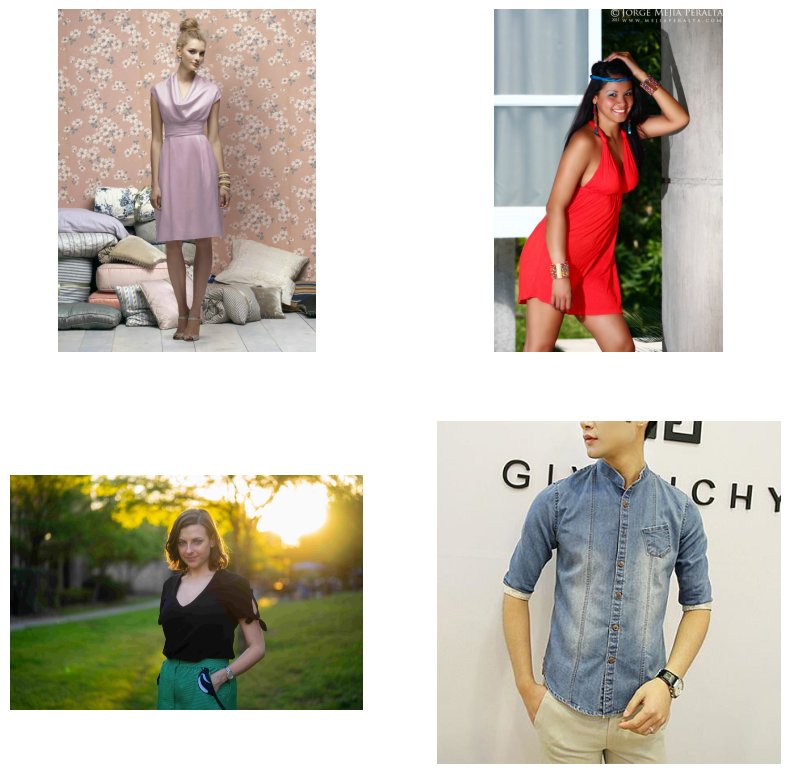

In [17]:
plot_multipanel(get_random_images(idx_sele, None))

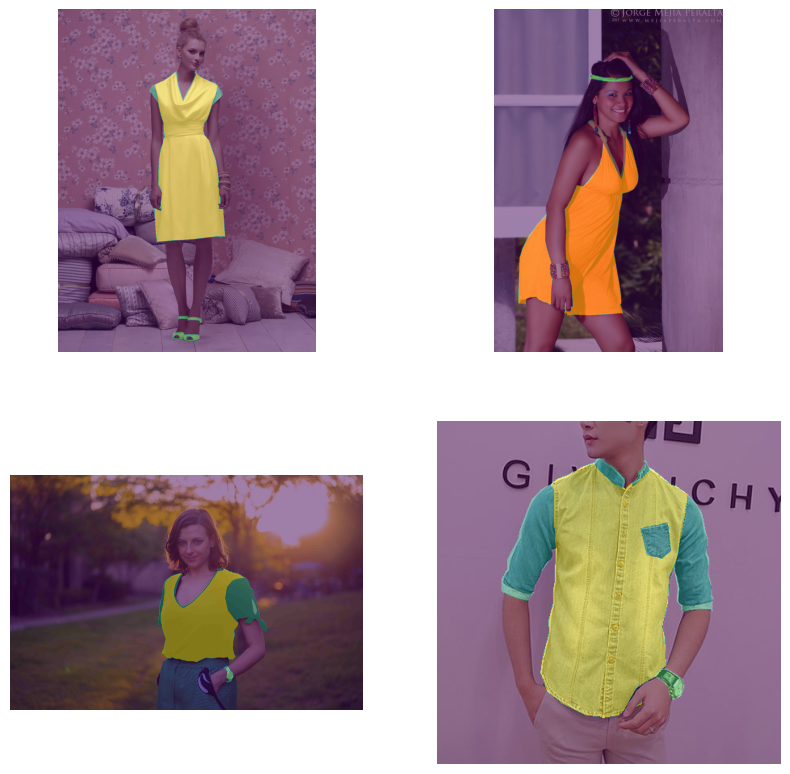

In [18]:
plot_multipanel(get_random_images(idx_sele, annot_train), True)

In [19]:
def read_labels(fname):
    """
    Reads labels json file as 2 DataFrames
    """
    with open(fname, "r") as fh:
        label_dict = json.load(fh);
    fh.close();
    
    categories = pd.DataFrame(label_dict["categories"]).sort_values(by="supercategory");
    attributes = pd.DataFrame(label_dict["attributes"]).sort_values(by="supercategory");
    return label_dict, categories, attributes;

DATA_DICT, CATEGORIES, ATTRIBUTES = read_labels(BASENAME+"label_descriptions.json");

In [20]:
USE_PRETRAINED = True; #depends on competition rule
NUM_CLASSES = len(np.unique(CATEGORIES.name));
NUM_ATTRS = len(np.unique(ATTRIBUTES.name));
print("Number of categoires & attributes are: %d & %d, respectively" % (NUM_CLASSES, NUM_ATTRS))

Number of categoires & attributes are: 46 & 294, respectively


## Keras-based _Mask RCNN_

References: 

* Most popular notebook in _iMaterialist_
* [PyImageSearch](https://www.pyimagesearch.com/2019/06/10/keras-mask-r-cnn/)
* Dr. J. Brownee's [tutorial](https://machinelearningmastery.com/how-to-perform-object-detection-in-photographs-with-mask-r-cnn-in-keras/)

In [21]:
len(CATEGORIES)

46

In [23]:
class CustomConfig(Config):
    """
    Configurations for matterport's MaskRCNN
    :reference github.com/matterport/Mask_RCNN/wiki
    :reference www.kaggle.com/kaushal2896/imaterialist-2020-starter-eda-mask-rcnn
    """
    NAME = "kaggle"
    BACKBONE = "resnet50"; #smaller memory requirement than resnet101 default
    GPU_COUNT = 1; 
    IMAGES_PER_GPU = 8; #can be even smaller, e.g. 2

    NUM_CLASSES = len(CATEGORIES) + 1; #extra background class
    
    ## Image sizes:
    IMAGE_MIN_DIM = 256;
    IMAGE_MAX_DIM = IMAGE_MIN_DIM;

    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128);
    TRAIN_ROIS_PER_IMAGE = 32; 
    STEPS_PER_EPOCH = 16; #TODO: consider larger at the end, e.g. 128
    VALIDATION_STEPS = 4;

CONFIG = CustomConfig();
CONFIG.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES 

In [24]:
class CustomDataset(Dataset):
    def __init__(self, df):
        super().__init__(self);
        self.IMAGE_SIZE = 256;
        
        for c in DATA_DICT["categories"]:
            self.add_class("dataset", c.get("id"), c.get("name"));
            
        for i, row in df.iterrows():
            self.add_image(
                "dataset", 
                image_id = row.name,   
                path = str(DATA_DIR/'train'/row.name) + '.jpg', 
                labels = row["ClassId"],
                annotations = row["EncodedPixels"], 
                height = row["Height"], 
                width = row["Width"]
            );
            
    def _resize_image(self, image_path):
        shape = (self.IMAGE_SIZE, self.IMAGE_SIZE);
        img = cv2.imread(image_path);
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB);
        img = cv2.resize(img, shape, interpolation=cv2.INTER_AREA);
        return img;
    
    def load_image(self, image_id):
        annot = self.image_info[image_id];
        return self._resize_image(annot["path"]);
    
    def image_reference(self, image_id):
        annot = self.image_info[image_id];
        return annot["path"], [label for label in annot["labels"]];
    
    def load_mask(self, image_id):
        annot = self.image_info[image_id];
        shape_r2 = (self.IMAGE_SIZE, self.IMAGE_SIZE);
        shape_r3 = (self.IMAGE_SIZE, self.IMAGE_SIZE, len(annot["annotations"]));
        mask = np.zeros(shape_r3, dtype=np.uint8);
        
        labels = [];
        for m, (annotation,label) in enumerate(zip(annot["annotations"],annot["labels"])):
            sub_mask = np.full(annot['height']*annot['width'], 0, dtype=np.uint8);
            annotation = [int(x) for x in annotation.split(" ")];
            
            for i, start_px in enumerate(annotation[::2]):
                end_px = start_px + annotation[2*i + 1];
                sub_mask[start_px : end_px] = 1;

            sub_mask = sub_mask.reshape((annot["height"],annot["width"]), order='F');
            sub_mask = cv2.resize(sub_mask, shape_r2, interpolation=cv2.INTER_NEAREST);
            
            mask[:, :, m] = sub_mask;
            labels.append(int(label)+1);
        
        return mask, np.array(labels);

In [26]:
def get_image_df(df, key="ImageId", agg_fun=lambda x:list(x)):
    """
    Wrapper to prepare training annotation
    """
    image_df = df.groupby(key)["EncodedPixels","ClassId"].agg(agg_fun);
    size_df = df.groupby(key)["Height","Width"].mean();
    image_df = image_df.join(size_df, on=key);
    
    print("Total images: %d" % len(image_df))
    image_df.head()
    return image_df;

annot_train.drop("AttributesIds", axis=1, inplace=True);
image_df = get_image_df(annot_train);

Total images: 45623


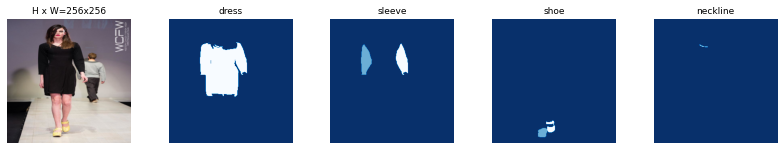

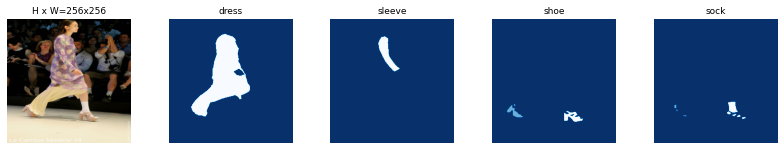

In [27]:
## For development, sub-sample the training set
N_SAMP = 1024;
VAL_PROP = 0.20; #use higher in actual analysis

image_df = image_df.iloc[np.random.choice(range(image_df.shape[0]), N_SAMP)];

def preview_mrcnn_data(dataset, num_imgs=2):
    """
    Wrapper to visualize a few images
    """
    dataset = CustomDataset(dataset);
    dataset.prepare();
    
    for i in range(num_imgs):
        image_id = np.random.choice(dataset.image_ids);
        image = dataset.load_image(image_id);
        mask, class_ids = dataset.load_mask(image_id);
        visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)

preview_mrcnn_data(image_df);

In [28]:
## Separately create training & validation sets:
imgs_train, imgs_val = train_test_split(image_df, test_size=VAL_PROP);

Xtrain = CustomDataset(imgs_train); 
Xtrain.prepare();
print("Training Data object: %s" % Xtrain) #ensure NOT Nonetype

Xval = CustomDataset(imgs_train);
Xval.prepare();
print("Validation Data object: %s" % Xval)

Training Data object: <__main__.CustomDataset object at 0x7f4f55d6d990>
Validation Data object: <__main__.CustomDataset object at 0x7f4f68d3ef50>


In [ ]:
model = MaskRCNN(mode="training", config=CONFIG, model_dir=ROOT_DIR);

In [ ]:
## Optional Steps:
## 1. Fine-tune with weights
## 2. Data augmentation, e.g. horizontal flip, white noise, random crop...

## Hacky solution to package update: Trick the system to believe that keras.engine.saving actually exists
H5_EXCL = ["mrcnn_class_logits","mrcnn_bbox_fc","mrcnn_bbox","mrcnn_mask"];
model.load_weights(FT_PATH, by_name=True, exclude=H5_EXCL);

In [ ]:
model.train(
    Xtrain, 
    Xval,
    learning_rate = 0.01,
    epochs = 1,
    layers = "heads",
    augmentation = None
);